# **COMP5703 - Postgraduate Capstone Project**

## **SMALL OBJECT DETECTION ON AN UNCREWED SURFACE VESSEL**

------------------------------------------------------------------------
### Group Number: CS5-2
------------------------------------------------------------------------
### SID: 500227956; 520370197; 540323234; 540033724; 540479597
------------------------------------------------------------------------

# **Model - EfficientDet-Pytorch**

### **Import Libraries**

In [ ]:
# Standard Libraries
import os
import sys
import re
import json
import shutil
import random
import subprocess
import itertools
from pathlib import Path
from datetime import datetime

# Data Handling
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Image Processing
import cv2

# Progress Bar
from tqdm import tqdm

# PyTorch Core
import torch

## **1. Data Preprocessing**

In [ ]:
# Parameter settings
source_dir = "F:/MOANA_Dataset/label_data/X-band"
target_base = "F:/COMP5703_Project/dataset/moana"
train_ratio = 0.8

# Create target structure
for sub in ["train", "val", "annotations"]:
    os.makedirs(os.path.join(target_base, sub), exist_ok=True)

# Get all pairing data
data_pairs = []
for f in os.listdir(source_dir):
    if f.endswith(".json"):
        base = f.replace(".json", "")
        img_path = os.path.join(source_dir, base + ".png")
        json_path = os.path.join(source_dir, f)
        if os.path.exists(img_path):
            data_pairs.append((img_path, json_path))

# Shuffle and divide the data
random.shuffle(data_pairs)
split = int(len(data_pairs) * train_ratio)
train_pairs = data_pairs[:split]
val_pairs = data_pairs[split:]

# COCO annotation initialization template
def coco_template():
    return {
        "info": {
            "description": "MOANA Radar Dataset",
            "version": "1.0",
            "date_created": datetime.now().isoformat()
        },
        "images": [],
        "annotations": [],
        "categories": [{"id": 1, "name": "vessel", "supercategory": "object"}]
    }

def convert_and_copy(pairs, split_name):
    output_img_dir = os.path.join(target_base, split_name)
    coco = coco_template()
    ann_id = 1

    for img_id, (img_path, json_path) in enumerate(tqdm(pairs)):
        # Copy the image
        dst_img_path = os.path.join(output_img_dir, Path(img_path).name)
        shutil.copyfile(img_path, dst_img_path)

        # Reading raw JSON tags
        with open(json_path, 'r') as f:
            data = json.load(f)

        width = data['image']['width']
        height = data['image']['height']
        file_name = data['image']['file_name']

        coco["images"].append({
            "id": img_id,
            "file_name": file_name,
            "width": width,
            "height": height
        })

        for obj in data["annotations"]:
            xmin = obj["xmin"]
            ymin = obj["ymin"]
            w = obj["width"]
            h = obj["height"]

            coco["annotations"].append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": 1,
                "bbox": [xmin, ymin, w, h],
                "area": w * h,
                "iscrowd": 0
            })
            ann_id += 1

    # Write COCO JSON
    out_json = os.path.join(target_base, "annotations", f"instances_{split_name}.json")
    with open(out_json, "w") as f:
        json.dump(coco, f, indent=2)

# Perform conversion and tidying
convert_and_copy(train_pairs, "train")
convert_and_copy(val_pairs, "val")

In [ ]:
moana_yaml = """
project_name: moana
train_set: train
val_set: val
num_gpus: 1

mean: [0.485, 0.456, 0.406]
std: [0.229, 0.224, 0.225]

anchors_scales: '[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)]'
anchors_ratios: '[(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)]'

obj_list: ['object']
"""

with open("F:\\COMP5703_Project\\Yet-Another-EfficientDet-Pytorch-master\\projects\\moana.yml", "w") as f:
    f.write(moana_yaml)

print("The moana.yml configuration file has been successfully created")

In [ ]:
!pip install tensorboardX

In [ ]:
%cd /content/drive/MyDrive/COMP5703/Yet-Another-EfficientDet-Pytorch-master

In [ ]:
!ln -s /content/drive/MyDrive/COMP5703/dataset /content/drive/MyDrive/COMP5703/Yet-Another-EfficientDet-Pytorch-master/datasets

### **2. Train (Running on Colab)**

#### **2.1. EfficientDet Training (100 epochs)**

In [ ]:
!python train.py \
  -p moana \
  -c 2 \
  --batch_size 4 \
  -n 2 \
  --lr 1e-4 \
  --num_epochs 100 \
  --data_path /content/drive/MyDrive/COMP5703/dataset \
  --saved_path /content/drive/MyDrive/COMP5703/train/logs \
  --load_weights weights/efficientdet-d2.pth \
  --head_only True

#### **2.2. EfficientDet Evaluation (100 epochs)**

In [ ]:
# Automatically collect model files and extract weight files with epoch number >= 65
model_dir = "F:/COMP5703_Project/Hyperparameter_Tuning/moana"
pth_files = sorted([
    f for f in os.listdir(model_dir)
    if f.endswith(".pth") and int(re.search(r"d2_(\d+)_", f).group(1)) >= 65
], key=lambda x: int(re.search(r"d2_(\d+)_", x).group(1)))

results = []

for pth in pth_files:
    epoch = int(re.search(r"d2_(\d+)_", pth).group(1))
    label = f"Epoch {epoch}"

    cmd = [
        "python", "F:/COMP5703_Project/Yet-Another-EfficientDet-Pytorch-master/coco_eval.py",
        "-p", "moana",
        "-c", "2",
        "-w", os.path.join(model_dir, pth),
        "--override", "True"
    ]

    output = subprocess.run(cmd, capture_output=True, text=True)
    result = output.stdout + output.stderr

    print(f"\n===== Output for {label} =====\n")
    print(result)

    mAP50 = re.search(r"mAP50:\s*([0-9.]+)", result)
    mAP5095 = re.search(r"mAP50_95:\s*([0-9.]+)", result)
    recall = re.search(r"recall:\s*([0-9.]+)", result)
    precision = re.search(r"precision:\s*([0-9.]+)", result)

    results.append({
        "epoch": epoch,
        "mAP50": float(mAP50.group(1)) if mAP50 else 0,
        "mAP5095": float(mAP5095.group(1)) if mAP5095 else 0,
        "recall": float(recall.group(1)) if recall else 0,
        "precision": float(precision.group(1)) if precision else 0,
    })


#### **2.3. EfficientDet Visualization (100 epochs)**

In [ ]:
# Sort by epoch
results = sorted(results, key = lambda x: x["epoch"])
epochs = [r["epoch"] for r in results]
mAP50 = [r["mAP50"] for r in results]
mAP5095 = [r["mAP5095"] for r in results]
recall = [r["recall"] for r in results]
precision = [r["precision"] for r in results]

fig, axs = plt.subplots(2, 2, figsize = (14, 10))
axs = axs.flatten()

axs[0].plot(epochs, mAP50, marker='o', color='blue')
axs[0].set_title("mAP@50")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Score")
axs[0].grid(True)

axs[1].plot(epochs, mAP5095, marker='o', color='orange')
axs[1].set_title("mAP@50-95")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Score")
axs[1].grid(True)

axs[2].plot(epochs, recall, marker='o', color='green')
axs[2].set_title("Recall")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Score")
axs[2].grid(True)

axs[3].plot(epochs, precision, marker='o', color='red')
axs[3].set_title("Precision")
axs[3].set_xlabel("Epoch")
axs[3].set_ylabel("Score")
axs[3].grid(True)

plt.tight_layout()
plt.show()

#### **From the image observation, pth 96 has the best indicators, and the detailed indicator information is output:**

In [ ]:
!python /content/drive/MyDrive/COMP5703/Yet-Another-EfficientDet-Pytorch-master/coco_eval.py \
  -p moana \
  -c 2 \
  -w /content/drive/MyDrive/COMP5703/train/logs/moana/efficientdet-d2_96_32000.pth \
  --override True

#### **Radar Image Visualization (with Bounding Boxes)**

In [ ]:
%cd /content/drive/MyDrive/COMP5703/Yet-Another-EfficientDet-Pytorch-master

!ln -s /content/drive/MyDrive/COMP5703/dataset /content/drive/MyDrive/COMP5703/Yet-Another-EfficientDet-Pytorch-master/datasets

In [ ]:
!python /content/drive/MyDrive/COMP5703/Yet-Another-EfficientDet-Pytorch-master/efficientdet_test.py

In [ ]:
image_dir = "/content/drive/MyDrive/COMP5703/test_output"
image_names = [
    "X_1724240748.png",
    "X_1724240773.png",
    "X_1724240747.png",
    "X_1724240672.png"
]

plt.figure(figsize = (12, 10))

for i, img_name in enumerate(image_names):
    img_path = os.path.join(image_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(img_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

### **3. Hyperparameter Tuning**

In [ ]:
!pip install tensorboardX

In [ ]:
%cd F:/COMP5703_Project/Yet-Another-EfficientDet-Pytorch-master

!ln -s F:/COMP5703_Project/Yet-Another-EfficientDet-Pytorch-master/datasets

#### **Learning Rate Tuning**

**momentum = 0.9; weight decay = 0.001; batch size = 3; compound_coef = 2**

In [ ]:
# Define hyperparameter space
lr_list = [0.001, 0.005, 0.01]
momentum_list = [0.9]
weight_decay_list = [0.001]
batch_size_list = [3]
compound_coef_list = [2]

# Generate all hyperparameter combinations
param_grid = list(itertools.product(lr_list, momentum_list, weight_decay_list, batch_size_list, compound_coef_list))

# Create DataFrame to display combinations
param_df = pd.DataFrame(param_grid, columns = ["lr", "momentum", "weight_decay", "batch_size", "compound_coef"])
param_df

In [ ]:
for lr, momentum, weight_decay, batch_size, coef in param_grid:
  !python train.py \
    -p moana \
    -c {coef} \
    --batch_size {batch_size} \
    --lr {lr} \
    --num_epochs 25 \
    --data_path F:/COMP5703_Project/datasets \
    --saved_path F:/COMP5703_Project/Hyperparameter_Tuning \
    --load_weights weights/efficientdet-d{coef}.pth \
    --head_only True \
    --momentum {momentum} \
    --weight_decay {weight_decay}

### **Visualization - Learning Rate**

In [ ]:
# Model directory paths
model_dir = "F:/COMP5703_Project/Hyperparameter_Tuning/moana"
eval_script = "F:/COMP5703_Project/Yet-Another-EfficientDet-Pytorch-master/coco_eval.py"

# Collect all .pth model files
pth_files = sorted([
    f for f in os.listdir(model_dir)
    if f.endswith(".pth")
])

# Group models by learning rate
lr_groups = {"0.001": [], "0.005": [], "0.01": []}

for f in pth_files:
    match = re.search(r'lr(0\.001|0\.005|0\.01)_.*?_ep(\d+)', f)
    if match:
        lr = match.group(1)
        epoch = int(match.group(2))
        lr_groups[lr].append((epoch, f))

# Run coco_eval and collect results
results_by_lr = {lr: [] for lr in lr_groups}

for lr, models in lr_groups.items():
    for epoch, pth in sorted(models):
        pth_path = os.path.join(model_dir, pth)
        label = f"Epoch {epoch}"

        cmd = [
            sys.executable,
            eval_script,
            "-p", "moana",
            "-c", "2",
            "-w", pth_path,
            "--override", "True"
        ]

        print(f"Running eval on: {pth}")
        output = subprocess.run(cmd, capture_output = True, text = True)
        result = output.stdout + output.stderr

        mAP50 = re.search(r"mAP50:\s*([0-9.]+)", result)
        mAP5095 = re.search(r"mAP50_95:\s*([0-9.]+)", result)
        recall = re.search(r"recall:\s*([0-9.]+)", result)
        precision = re.search(r"precision:\s*([0-9.]+)", result)

        results_by_lr[lr].append({
            "epoch": epoch,
            "mAP50": float(mAP50.group(1)) if mAP50 else 0,
            "mAP5095": float(mAP5095.group(1)) if mAP5095 else 0,
            "recall": float(recall.group(1)) if recall else 0,
            "precision": float(precision.group(1)) if precision else 0,
        })

# Visualize results
fig, axs = plt.subplots(2, 2, figsize = (14, 10))
axs = axs.flatten()

metrics_names = ["mAP50", "mAP5095", "recall", "precision"]
colors = {"0.001": "blue", "0.005": "green", "0.01": "red"}

for i, metric in enumerate(metrics_names):
    ax = axs[i]
    for lr, results in results_by_lr.items():
        results_sorted = sorted(results, key = lambda x: x["epoch"])
        epochs = [r["epoch"] for r in results_sorted]
        values = [r[metric] for r in results_sorted]
        ax.plot(epochs, values, marker = 'o', label = f"lr = {lr}", color = colors[lr])

    ax.set_title(metric)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Score")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

#### **Momentum Tuning**

**learning rate = 0.001; weight decay = 0.001; batch size = 3; compound_coef = 2**

In [ ]:
# Define hyperparameter search space
lr_list = [0.001]
momentum_list = [0.9]
weight_decay_list = [0.0001, 0.0005, 0.001]
batch_size_list = [3]
compound_coef_list = [2]

param_grid = list(itertools.product(lr_list, momentum_list, weight_decay_list, batch_size_list, compound_coef_list))

param_df = pd.DataFrame(param_grid, columns=["lr", "momentum", "weight_decay", "batch_size", "compound_coef"])
param_df

In [ ]:
for lr, momentum, weight_decay, batch_size, coef in param_grid:
  !python train.py \
    -p moana \
    -c {coef} \
    --batch_size {batch_size} \
    --lr {lr} \
    --num_epochs 40 \
    --data_path F:/COMP5703_Project/datasets \
    --saved_path F:/COMP5703_Project/Hyperparameter_Tuning_momentum \
    --load_weights weights/efficientdet-d{coef}.pth \
    --head_only True \
    --momentum {momentum} \
    --weight_decay {weight_decay}

### **Visualization - Weight Decay**

In [ ]:
%cd F:/COMP5703_Project/Yet-Another-EfficientDet-Pytorch-master

In [ ]:
src = "F:/COMP5703_Project/Yet-Another-EfficientDet-Pytorch-master/datasets"
dst = "./datasets"

# If symbolic links are allowed on your system:
if not os.path.exists(dst):
    os.symlink(src, dst)

In [ ]:
print("[INFO] CUDA Available:", torch.cuda.is_available())

# Change to project root directory
%cd F:/COMP5703_Project/Yet-Another-EfficientDet-Pytorch-master

# Create symlink for datasets (run once)
src = "F:/COMP5703_Project/Yet-Another-EfficientDet-Pytorch-master/datasets"
dst = "./datasets"
if not os.path.exists(dst):
    os.symlink(src, dst)

# Model directory and evaluation script path
model_dir = "F:/COMP5703_Project/Hyperparameter_Tuning_momentum/moana"
eval_script = "F:/COMP5703_Project/Yet-Another-EfficientDet-Pytorch-master/coco_eval.py"

# Collect all .pth model files
pth_files = sorted([f for f in os.listdir(model_dir) if f.endswith(".pth")])

# Group models by weight decay
wd_groups = {"0.0001": [], "0.0005": [], "0.001": []}
for f in pth_files:
    match = re.search(r'wd(0\.0001|0\.0005|0\.001)_.*?_ep(\d+)', f)
    if match:
        wd = match.group(1)
        epoch = int(match.group(2))
        wd_groups[wd].append((epoch, f))

# Initialize result storage
results_by_wd = {wd: [] for wd in wd_groups}

# Run evaluation
for wd, models in wd_groups.items():
    for epoch, pth in sorted(models):
        pth_path = os.path.join(model_dir, pth)

        cmd = [
            sys.executable,
            eval_script,
            "-p", "moana",
            "-c", "2",
            "-w", pth_path,
            "--override", "True",
            "--cuda", "True"
        ]

        print(f"\n[INFO] Running eval on: {pth}")
        print("[DEBUG] Command:", " ".join(cmd))
        output = subprocess.run(cmd, stdout = subprocess.PIPE, stderr = subprocess.PIPE, text = True)
        result = output.stdout + output.stderr
        print("[DEBUG] Result:\n", result)

        # Extract evaluation results
        mAP50 = re.search(r"mAP50:\s*([0-9.]+)", result)
        mAP5095 = re.search(r"mAP50_95:\s*([0-9.]+)", result)
        recall = re.search(r"recall:\s*([0-9.]+)", result)
        precision = re.search(r"precision:\s*([0-9.]+)", result)

        results_by_wd[wd].append({
            "epoch": epoch,
            "mAP50": float(mAP50.group(1)) if mAP50 else 0,
            "mAP5095": float(mAP5095.group(1)) if mAP5095 else 0,
            "recall": float(recall.group(1)) if recall else 0,
            "precision": float(precision.group(1)) if precision else 0,
        })

# Plot results
fig, axs = plt.subplots(2, 2, figsize = (14, 10))
axs = axs.flatten()

metrics_names = ["mAP50", "mAP5095", "recall", "precision"]
colors = {"0.0001": "blue", "0.0005": "green", "0.001": "red"}

for i, metric in enumerate(metrics_names):
    ax = axs[i]
    for wd, results in results_by_wd.items():
        results_sorted = sorted(results, key = lambda x: x["epoch"])
        epochs = [r["epoch"] for r in results_sorted]
        values = [r[metric] for r in results_sorted]
        ax.plot(epochs, values, marker = 'o', label = f"wd = {wd}", color = colors[wd])
    ax.set_title(metric)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Score")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

### **4. Final EfficientDet Model Training**

**Image Size change to 1024**

In [ ]:
%cd F:/COMP5703_Project/Yet-Another-EfficientDet-Pytorch-master

In [ ]:
src = "F:/COMP5703_Project/Yet-Another-EfficientDet-Pytorch-master/datasets"
dst = "./datasets"

# If symbolic links are allowed on your system:
if not os.path.exists(dst):
    os.symlink(src, dst)

In [ ]:
lr_list = [0.001]
momentum_list = [0.9]
weight_decay_list = [0.0005]
batch_size_list = [3]
compound_coef_list = [4]

param_grid = list(itertools.product(lr_list, momentum_list, weight_decay_list, batch_size_list, compound_coef_list))

param_df = pd.DataFrame(param_grid, columns = ["lr", "momentum", "weight_decay", "batch_size", "compound_coef"])
param_df

In [ ]:
for lr, momentum, weight_decay, batch_size, coef in param_grid:
  !python train.py \
    -p moana \
    -c {coef} \
    --batch_size {batch_size} \
    --lr {lr} \
    --num_epochs 100 \
    --data_path F:/COMP5703_Project/datasets \
    --saved_path F:/COMP5703_Project/Hyperparameter_Tuning_image_1024 \
    --load_weights weights/efficientdet-d2.pth \
    --head_only True \
    --momentum {momentum} \
    --weight_decay {weight_decay}

In [ ]:
# Original folder path
folder = "F:/COMP5703_Project/Hyperparameter_Tuning_image_1024/moana"

# Traverse all .pth files in the directory
for filename in os.listdir(folder):
    if filename.endswith(".pth"):
        # Match epoch and steps
        match = re.search(r"ep(\d+)_st(\d+)", filename)
        if match:
            epoch = match.group(1)
            steps = match.group(2)

            # Construct a new file name
            new_filename = f"efficientdet-d4_{epoch}_{steps}.pth"

            # Construct full path
            old_path = os.path.join(folder, filename)
            new_path = os.path.join(folder, new_filename)

            # Rename file
            os.rename(old_path, new_path)
            print(f"Renamed: {filename} -> {new_filename}")

### **Visualization - Final Model**

In [ ]:
# Set model directory and evaluation script
model_dir = "F:/COMP5703_Project/Hyperparameter_Tuning_image_1024/moana"
eval_script = "F:/COMP5703_Project/Yet-Another-EfficientDet-Pytorch-master/coco_eval.py"

# Group models by label
group_key = "image1024"
grouped_models = {group_key: []}

# Collect .pth files with epoch >= 50
pth_files = sorted([
    f for f in os.listdir(model_dir)
    if f.endswith(".pth") and re.search(r'd\d+_ep(\d+)_st\d+\.pth', f) and int(re.search(r'd\d+_ep(\d+)_st\d+\.pth', f).group(1)) >= 50
], key=lambda x: int(re.search(r'd\d+_ep(\d+)_st\d+\.pth', x).group(1)))

# Parse filenames into (epoch, filename) for evaluation
for f in pth_files:
    epoch = int(re.search(r'd\d+_ep(\d+)_st\d+\.pth', f).group(1))
    grouped_models[group_key].append((epoch, f))

# Storage for results
results_by_group = {key: [] for key in grouped_models}

# Evaluate all grouped models
for key, models in grouped_models.items():
    for epoch, pth_file in sorted(models):
        pth_path = os.path.join(model_dir, pth_file)

        # Use the file's naming to let coco_eval.py auto-extract compound_coef
        cmd = [
            sys.executable, eval_script,
            "-p", "moana",
            "-w", pth_path,
            "--override", "True",
            "--cuda", "True"
        ]

        print(f"\n[INFO] Running eval on: {pth_file}")
        print("[DEBUG] Command:", " ".join(cmd))
        output = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        result = output.stdout + output.stderr
        print("[DEBUG] Result:\n", result)

        # Extract evaluation results
        mAP50 = re.search(r"mAP50:\s*([0-9.]+)", result)
        mAP5095 = re.search(r"mAP50_95:\s*([0-9.]+)", result)
        recall = re.search(r"recall:\s*([0-9.]+)", result)
        precision = re.search(r"precision:\s*([0-9.]+)", result)

        results_by_group[key].append({
            "epoch": epoch,
            "mAP50": float(mAP50.group(1)) if mAP50 else 0,
            "mAP5095": float(mAP5095.group(1)) if mAP5095 else 0,
            "recall": float(recall.group(1)) if recall else 0,
            "precision": float(precision.group(1)) if precision else 0,
        })

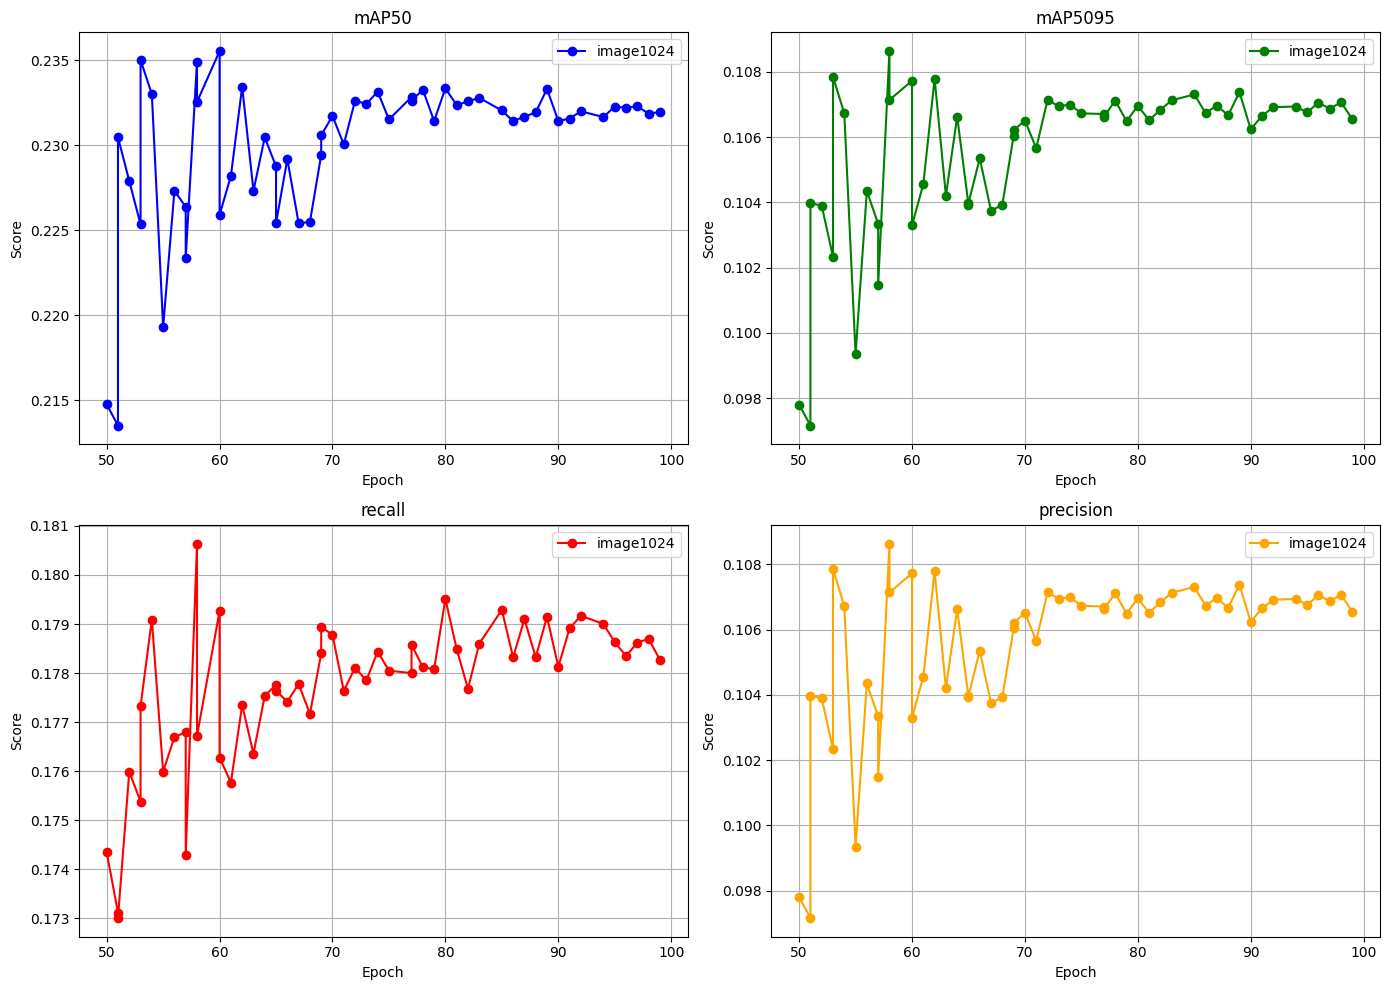

In [41]:
fig, axs = plt.subplots(2, 2, figsize = (14, 10))
axs = axs.flatten()

metrics_names = ["mAP50", "mAP5095", "recall", "precision"]

colors = itertools.cycle(['blue', 'green', 'red', 'orange', 'purple'])

for i, metric in enumerate(metrics_names):
    ax = axs[i]
    for key, results in results_by_group.items():
        color = next(colors)
        results_sorted = sorted(results, key=lambda x: x["epoch"])
        epochs = [r["epoch"] for r in results_sorted]
        values = [r[metric] for r in results_sorted]
        ax.plot(epochs, values, marker='o', label=key, color=color)
    ax.set_title(metric)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Score")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [42]:
pth_path = "F:/COMP5703_Project/Hyperparameter_Tuning_image_1024/moana/efficientdet-d4_ep58_st26000.pth"
eval_script = "F:/COMP5703_Project/Yet-Another-EfficientDet-Pytorch-master/coco_eval.py"

cmd = [
    sys.executable,
    eval_script,
    "-p", "moana",
    "-w", pth_path,
    "--override", "True",
    "--cuda", "True"
]


result = subprocess.run(cmd, stdout = subprocess.PIPE, stderr = subprocess.PIPE, text = True)
print(result.stdout)
print(result.stderr)

[INFO] compound_coef automatically set to: d4
running coco-style evaluation on project moana, weights F:/COMP5703_Project/Hyperparameter_Tuning_image_1024/moana/efficientdet-d4_ep58_st26000.pth...
[INFO] use_cuda: True, device: 0, weight: F:/COMP5703_Project/Hyperparameter_Tuning_image_1024/moana/efficientdet-d4_ep58_st26000.pth
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
[INFO] Model is using device: cuda:0
[INFO] Model is using device: cuda:0
[INFO] Model is using device: cuda:0
[INFO] Model is using device: cuda:0
[INFO] Model is using device: cuda:0
[INFO] Model is using device: cuda:0
[INFO] Model is using device: cuda:0
[INFO] Model is using device: cuda:0
[INFO] Model is using device: cuda:0
[INFO] Model is using device: cuda:0
[INFO] Model is using device: cuda:0
[INFO] Model is using device: cuda:0
[INFO] Model is using device: cuda:0
[INFO] Model is using device: cuda:0
[INFO] Model is using device: cuda:0
[INFO] Model is using device: c

#### **Radar Image Visualization (with Bounding Boxes)**

In [46]:
cmd = [
    sys.executable,
    "F:/COMP5703_Project/Yet-Another-EfficientDet-Pytorch-master/efficientdet_test.py",
    "-w", "F:/COMP5703_Project/Hyperparameter_Tuning_image_1024/moana/efficientdet-d4_ep58_st26000.pth",
    "-i", "F:/COMP5703_Project/datasets/moana/val/",
    "-o", "F:/COMP5703_Project/test_output/",
    "-c", "4",
    "--threshold", "0.3",
    "--iou_threshold", "0.2",
    "--cuda", "True",
    "--float16", "False"
]

result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

print("[STDOUT]\n", result.stdout)
print("[STDERR]\n", result.stderr)

[STDOUT]
 
Done. 331 images saved to: F:/COMP5703_Project/test_output/

[STDERR]
 
Inference: 100%|██████████| 331/331 [01:49<00:00,  3.02it/s]



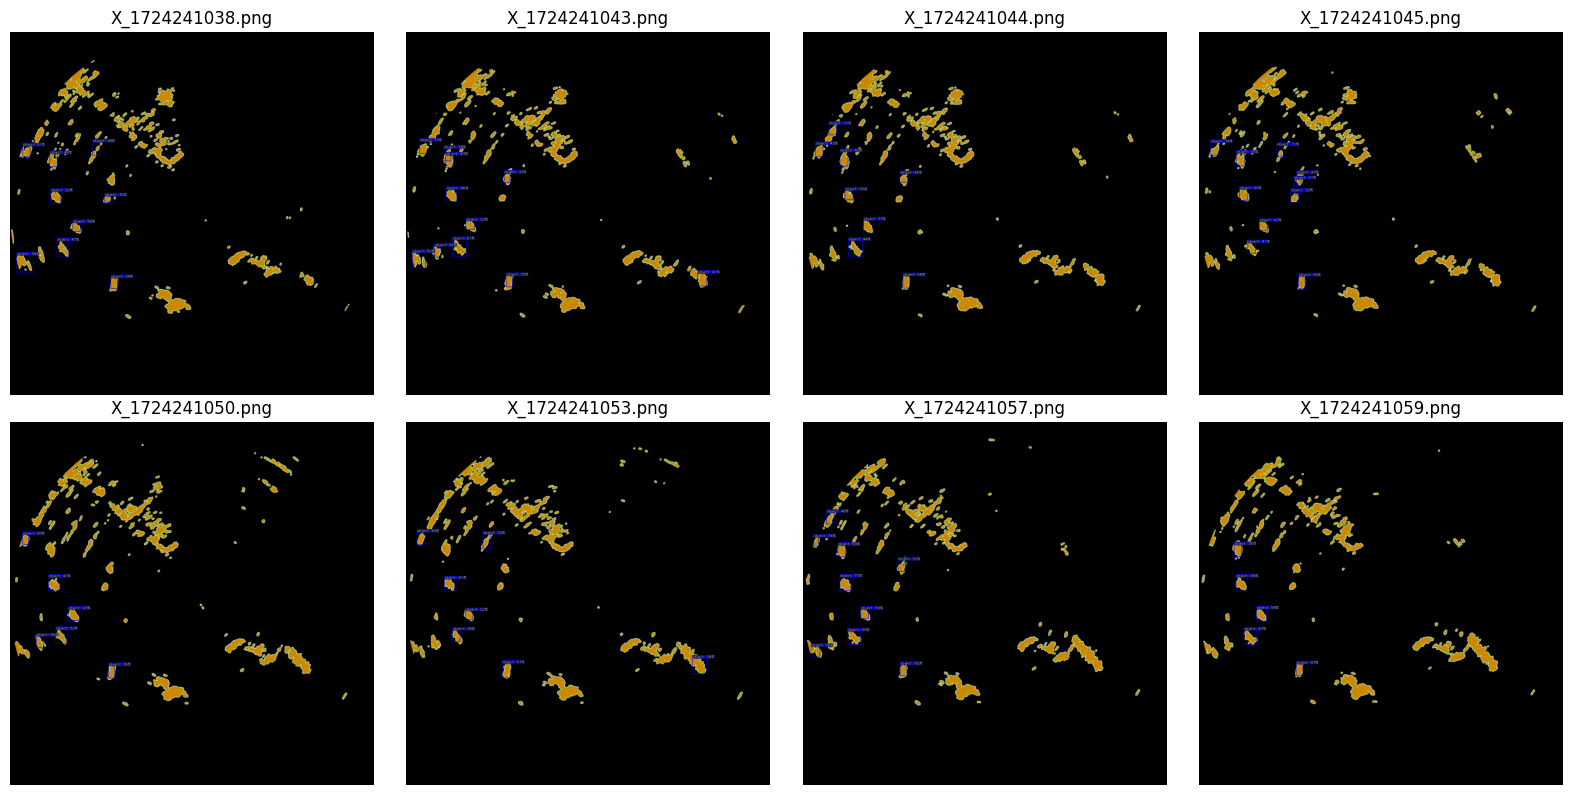

In [47]:
image_dir = "F:/COMP5703_Project/test_output"

# Image filenames to display
image_names = [
    "X_1724241038.png",
    "X_1724241043.png",
    "X_1724241044.png",
    "X_1724241045.png",
    "X_1724241050.png",
    "X_1724241053.png",
    "X_1724241057.png",
    "X_1724241059.png"
]

# Create a canvas of 2 rows and 4 columns
plt.figure(figsize=(16, 8))  # Width x Height

# Loop through each image and plot
for i, img_name in enumerate(image_names):
    img_path = os.path.join(image_dir, img_name)
    img = cv2.imread(img_path)  # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    plt.subplot(2, 4, i + 1)  # 2 rows, 4 columns
    plt.imshow(img)
    plt.title(img_name)
    plt.axis("off")  # Hide axes

# Optimize layout and show all images
plt.tight_layout()
plt.show()